In [11]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z
import math


# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [12]:
# Importing standard Qiskit modules
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter

from qiskit.quantum_info import state_fidelity

import math
import numpy as np
from scipy.special import erf

# Qiskit Pulse imports
import qiskit.pulse
from qiskit import pulse
from qiskit.pulse import library

from qiskit import *
from qiskit.pulse import Play, Schedule, DriveChannel, ControlChannel, Waveform, ShiftPhase
from qiskit.pulse.library import drag, GaussianSquare, Drag

import qiskit
import qiskit.quantum_info as qi


from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [13]:
from qiskit import IBMQ
IBMQ.save_account("",overwrite=True)
IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-03-07 17:45:36,828: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [4]:
provider = IBMQ.get_provider()
backend = provider.get_backend('ibmq_casablanca')

properties = backend.properties()

QiskitBackendNotFoundError: 'No backend matches the criteria'

In [ ]:
backend_config = backend.configuration()
ham_params = backend_config.hamiltonian['vars']
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")

In [ ]:
backend_defaults = backend.defaults()
inst_sched_map = backend_defaults.instruction_schedule_map 
inst_sched_map.instructions

In [ ]:
def cx_pulse_instructions(qc: int, qt: int):
    """Retrieve the CNOT pulse schedule for the given
    qubit pair from the backend defaults.
    
    Args:
      qc: control qubit index
      qt: target qubit index
    """
    if [qc, qt] not in backend_config.coupling_map:
        print('Qubit pair has no direct cross resonance!')
    else:
        cx = inst_sched_map.get('cx', qubits=[qc, qt])
        return cx

def Exract_GaussianSquare(q1, q2):
    """Retrieve the Gaussiacross resonance pulse waveform
    for the qubit pair from the cx (CNOT) schedule.
    
    Args:
      q1: control qubit index
      q2: target qubit index
    """
    cx = cx_pulse_instructions(q1, q2)
    cx1 = cx_pulse_instructions(q2, q1)
    if cx.instructions[-1][0] < cx1.instructions[-1][0]:
        cx=cx1
    idx = 0
    Dr_gs = []
    cr_gs = []
    control_channel=''
    Drive_Channel=''
    another_Drive_Channel=''
    #look for first Play instruction on a ControlChannel
    N = 1
    for i in range(len(cx.instructions)):
        if type(cx.instructions[i][1]) is ShiftPhase and type(cx.instructions[i][1].channel) is DriveChannel\
        and cx.instructions[i][1].phase == -math.pi/2 and N == 1 :
            
            another_Drive_Channel=cx.instructions[i][1].channels[0]
            
        if type(cx.instructions[i][1].channels[0]) is ControlChannel and type(cx.instructions[i][1]) is Play\
          and type(cx.instructions[i][1].pulse) is GaussianSquare:

            cr_gs.append(cx.instructions[i][1].pulse)

            control_channel=cx.instructions[i][1].channels[0]

        if type(cx.instructions[i][1].channels[0]) is DriveChannel and type(cx.instructions[i][1]) is Play \
          and type(cx.instructions[i][1].pulse) is GaussianSquare:

            Dr_gs.append(cx.instructions[i][1].pulse)

            Drive_Channel=cx.instructions[i][1].channels[0]
        if type(cx.instructions[i][1]) is Play:
            N=0

    return control_channel, cr_gs, Drive_Channel, Dr_gs, another_Drive_Channel


def Get_Shift_phase_CRTL_Chan(q1, q2):
    """Get q1 and q2 corresponding control channel
    
    Args:
      q1: small one
      qt: target qubit index
    """
    cx1 = cx_pulse_instructions(q1, q2)
    cx2 = cx_pulse_instructions(q2, q1)
    if cx1.instructions[-1][0] > cx2.instructions[-1][0]:
        cx1, cx2 = cx2, cx1
    control_chan0 = []
    control_chan1 = []
    for i in range(len(cx2.instructions)):
        if type(cx2.instructions[i][1]) is ShiftPhase and type(cx2.instructions[i][1].channel) is ControlChannel\
        and cx2.instructions[i][1].phase == -math.pi/2 :
            control_chan0.append(cx2.instructions[i][1].channel)
        if type(cx2.instructions[i][1]) is ShiftPhase and type(cx2.instructions[i][1].channel) is ControlChannel\
        and cx2.instructions[i][1].phase == -math.pi :
            control_chan1.append(cx2.instructions[i][1].channel)
        if type(cx2.instructions[i][1]) is Play:
            break

    return control_chan0, control_chan1


def Rzz_90_gate_schedule (q0,q1):
    uchan, cr_pulse, Dchan, dr_pulse, another_Dchan = Exract_GaussianSquare(q0, q1)
    #Y_chan, X_chan = Get_XY_chan(q0,q1)
    control_chan0, control_chan1 = Get_Shift_phase_CRTL_Chan(q0, q1)
    
    
    Y_q = Dchan.index
    
    X_q = another_Dchan.index
    
    Y90p = inst_sched_map.get('u2', P0=0, P1=0, qubits=[Y_q]).instructions
    
    X_180 = inst_sched_map.get('x', qubits=[X_q]).instructions[0][1].pulse
    
    for Y in Y90p:
        if type(Y[1]) is Play:
            Y_pulse = Y[1].pulse
            
    drive_samples = Y_pulse.duration
    
    cr_samples = cr_pulse[0].duration
  
    Rzz_90_schedule = pulse.Schedule(name="RZZ gate m90 pulse") 
    
    Rzz_90_schedule |= ShiftPhase(-math.pi, Dchan) #<< int(2*cr_samples+2*drive_samples)
    
    for chan in control_chan1:
        Rzz_90_schedule |= ShiftPhase(-math.pi, chan) #<< int(2*cr_samples+2*drive_samples)
    
    Rzz_90_schedule |= Play(Y_pulse, Dchan)
    
    Rzz_90_schedule |= ShiftPhase(-math.pi, Dchan) << int(drive_samples)
    
    for chan in control_chan1: 
        Rzz_90_schedule |= ShiftPhase(-math.pi, chan) << int(drive_samples)

    
    Rzz_90_schedule |= Play(dr_pulse[0], Dchan) << int(drive_samples)
    Rzz_90_schedule |= Play(cr_pulse[0], uchan) << int(drive_samples)
    
    Rzz_90_schedule |= Play(X_180, another_Dchan) << int(cr_samples+drive_samples)

    Rzz_90_schedule |= Play(dr_pulse[1], Dchan) << int(cr_samples+2*drive_samples)
    Rzz_90_schedule |= Play(cr_pulse[1], uchan) << int(cr_samples+2*drive_samples)
    
    Rzz_90_schedule |= Play(X_180, another_Dchan) << int(2*cr_samples+2*drive_samples)

    Rzz_90_schedule |= Play(Y_pulse, Dchan) << int(2*cr_samples+2*drive_samples)
    
    return Rzz_90_schedule

def Rzz_gate_schedule (q0,q1,theta):
    
    uchan, cr_pulse, Dchan, dr_pulse, another_Dchan = Exract_GaussianSquare(q0, q1)
    #Y_chan, X_chan = Get_XY_chan(q0,q1)
    control_chan0, control_chan1 = Get_Shift_phase_CRTL_Chan(q0, q1)
    
    Frac = 2*np.abs(theta)/math.pi
    
    Y_q = Dchan.index
    
    X_q = another_Dchan.index
    
    Y90p = inst_sched_map.get('u2', P0=0, P1=0, qubits=[Y_q]).instructions
    
    X_180 = inst_sched_map.get('x', qubits=[X_q]).instructions[0][1].pulse
    
    ### find out Y_90 pulse 
    
    for Y in Y90p:
        
        if type(Y[1]) is Play:
            
            Y_pulse = Y[1].pulse
            
    ###
            
    drive_samples = Y_pulse.duration
    
    cr_samples = cr_pulse[0].duration
    
    cr_width= cr_pulse[0].width
    
    cr_sigma = cr_pulse[0].sigma
    
    cr_amp = np.abs(cr_pulse[0].amp)
    
    number_std = (cr_samples-cr_width)/cr_sigma
    
    Area_g = cr_amp*cr_sigma*np.sqrt(2*np.pi)*erf(number_std) 
    
    Area_pi_2 = cr_width*cr_amp+Area_g 
    
    dr_sigma = dr_pulse[0].sigma
    
    dr_amp = np.abs(dr_pulse[0].amp)
    
    Area_theta = Frac * Area_pi_2
    
    if Area_theta > Area_g:
        
        New_width = (Area_theta-Area_g)/cr_amp
        
        new_duration = math.ceil((New_width+number_std*cr_sigma)/16)*16
        
        cr_pulse[0] = GaussianSquare(duration=new_duration, amp=cr_pulse[0].amp, sigma=cr_sigma, width=New_width)
        
        cr_pulse[1] = GaussianSquare(duration=new_duration, amp=-cr_pulse[0].amp, sigma=cr_sigma, width=New_width)
        
        dr_pulse[0] = GaussianSquare(duration=new_duration, amp=dr_pulse[0].amp, sigma=dr_sigma, width=New_width)
        
        dr_pulse[1] = GaussianSquare(duration=new_duration, amp=-dr_pulse[0].amp, sigma=dr_sigma, width=New_width)
        
        
    else:
        
        New_amp_cr =  cr_pulse[0].amp*Area_theta/Area_g
        
        New_amp_dr= dr_pulse[0].amp*Area_theta/Area_g
        
        new_duration = number_std * cr_sigma
        
        cr_pulse[0] = GaussianSquare(duration=int(new_duration), amp=New_amp_cr, sigma=cr_sigma, width=0)
        
        cr_pulse[1] = GaussianSquare(duration=int(new_duration), amp=-New_amp_cr, sigma=cr_sigma, width=0)
        
        dr_pulse[0] = GaussianSquare(duration=int(new_duration), amp=New_amp_dr, sigma=dr_sigma, width=0)
        
        dr_pulse[1] = GaussianSquare(duration=int(new_duration), amp=-New_amp_dr, sigma=dr_sigma, width=0)
        
    # Set up the Rzz schedule
    if theta < 0 :
  
        RZZ_schedule = pulse.Schedule(name="RZZ gate pulse") 
    
        ### Y_-90 pulse
    
        RZZ_schedule |= ShiftPhase(-math.pi, Dchan) 
    
        for chan in control_chan1:
            
            RZZ_schedule |= ShiftPhase(-math.pi, chan) 
    
        RZZ_schedule |= Play(Y_pulse, Dchan)
    
        RZZ_schedule |= ShiftPhase(-math.pi, Dchan) << int(drive_samples)
    
        for chan in control_chan1: 
        
            RZZ_schedule |= ShiftPhase(-math.pi, chan) << int(drive_samples)
        
         ### 
    
         ### Cross resonant pulses and X rotation echo pulse
    
        RZZ_schedule |= Play(dr_pulse[0], Dchan) << int(drive_samples)
        RZZ_schedule |= Play(cr_pulse[0], uchan) << int(drive_samples)
    
        RZZ_schedule |= Play(X_180, another_Dchan) << int(new_duration+drive_samples)

        RZZ_schedule |= Play(dr_pulse[1], Dchan) << int(new_duration+2*drive_samples)
        RZZ_schedule |= Play(cr_pulse[1], uchan) << int(new_duration+2*drive_samples)
    
         ###
    
         ### X_180 pulse
    
        RZZ_schedule |= Play(X_180, another_Dchan) << int(2*new_duration+2*drive_samples)
    
         ## Y_90 pulse

        RZZ_schedule |= Play(Y_pulse, Dchan) << int(2*new_duration+2*drive_samples)
    
        return RZZ_schedule
    
    else:
        
        RZZ_schedule = pulse.Schedule(name="RZZ gate pulse") 
    
        ### Y_-90 pulse
    
        RZZ_schedule |= Play(Y_pulse, Dchan)
    
        
         ### 
    
         ### Cross resonant pulses and X rotation echo pulse
    
        RZZ_schedule |= Play(dr_pulse[0], Dchan) << int(drive_samples)
        RZZ_schedule |= Play(cr_pulse[0], uchan) << int(drive_samples)
    
        RZZ_schedule |= Play(X_180, another_Dchan) << int(new_duration+drive_samples)

        RZZ_schedule |= Play(dr_pulse[1], Dchan) << int(new_duration+2*drive_samples)
        RZZ_schedule |= Play(cr_pulse[1], uchan) << int(new_duration+2*drive_samples)
    
         ###
    
         ### X_180 pulse
    
        RZZ_schedule |= Play(X_180, another_Dchan) << int(2*new_duration+2*drive_samples)
    
         ## Y_90 pulse
        
        RZZ_schedule |= ShiftPhase(-math.pi, Dchan) << int(2*new_duration+2*drive_samples)
        
        for chan in control_chan1:
            
            RZZ_schedule |= ShiftPhase(-math.pi, chan) << int(2*new_duration+2*drive_samples)
        
        RZZ_schedule |= Play(Y_pulse, Dchan) << int(2*new_duration+2*drive_samples)
        
        RZZ_schedule |= ShiftPhase(-math.pi, Dchan) << int(2*new_duration+3*drive_samples)
    
        for chan in control_chan1: 
        
            RZZ_schedule |= ShiftPhase(-math.pi, chan) << int(2*new_duration+3*drive_samples)
    
        return RZZ_schedule

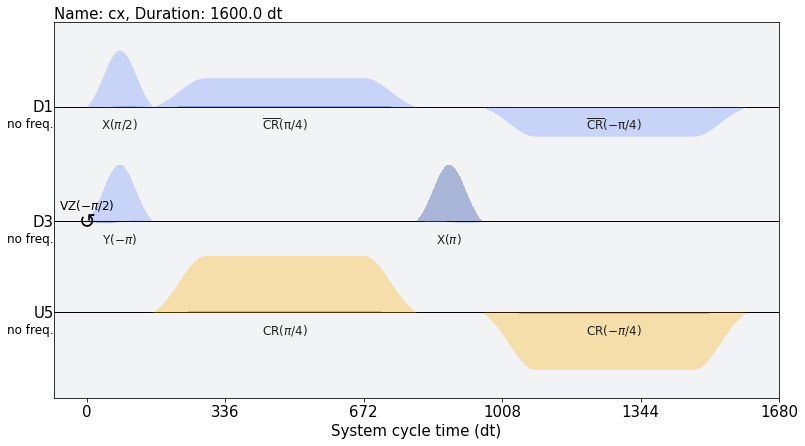

In [8]:
inst_sched_map.get('cx', qubits=[3, 1]).draw()

In [8]:
angle_lst=[0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4]

scale_lst=[1,2,3]


job_id={}

for angle in angle_lst:
    
    job_id[angle]=[]
    
    Fids_mean=[]

    Fids=[]

    for scale in scale_lst:

        qc1 = QuantumCircuit(2)

        ang=angle

        #for time in range(scale):

        qc1.rzz(ang,0,1)

        target_unitary = qi.Operator(qc1)

        qr = QuantumRegister(7)
        qc = QuantumCircuit(qr)

        q1=1

        q2=3

        qc.rzz(ang,q1,q2)

        for time in range(scale-1):

            qc.barrier()

            qc.rzz(ang,q1,q2)

            qc.barrier()

            qc.rzz(-ang,q1,q2)

        qc.add_calibration('rzz', [q1,q2], Rzz_gate_schedule(q1,q2,ang), [ang])

        qc.add_calibration('rzz', [q1,q2], Rzz_gate_schedule(q1,q2,-ang), [-ang])

        qpt_circs = process_tomography_circuits(qc, [qr[q1], qr[q2]])

        #st_qcs[-1].draw('mpl')

        qubits_list = [q1,q2]

        shots=8192

        qr = QuantumRegister(len(qubits_list),'q')

        meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

        init_layout = {}

        for i,j in enumerate(qubits_list):

            init_layout[qr[i]] = j

        cal_results = execute(meas_calibs, backend, shots=shots, initial_layout=init_layout)

        print('Job ID', cal_results.job_id())
        
        job_id[angle].append(cal_results.job_id())

        shots = 1024 #8192
        
        reps = 4

        #jobs = []
        for _ in range(reps):
            # execute

            job = execute(qpt_circs, backend, shots=shots)
            
            print('Job ID', job.job_id())

            job_id[angle].append(job.job_id())
            

Job ID 61eaface404aaeb7794382b9
Job ID 61eafad06fb797ea34442304
Job ID 61eafad34eebdaf3d77a8867
Job ID 61eafad56fb7973326442305
Job ID 61eafad8ded89e50eda9e5f4
Job ID 61eafad8404aae270a4382bd
Job ID 61eafadb1faa063135345bbc
Job ID 61eafadd4ddc9fb16e80d51b
Job ID 61eafadf1faa06d124345bbd
Job ID 61eafae21faa06929b345bbe
Job ID 61eafae29847b384dcab0d51
Job ID 61eafae5404aae51594382be
Job ID 61eafae71faa06023d345bc0
Job ID 61eafae99847b35d5aab0d53
Job ID 61eafaec1faa064f23345bc1
Job ID 61eafaedd6c095411edfac96
Job ID 61eafaef9847b38006ab0d54
Job ID 61eafaf19847b3fba8ab0d55
Job ID 61eafaf34eebda316e7a8869
Job ID 61eafaf64ddc9f0f0e80d51f
Job ID 61eafaf6404aae33d94382c2
Job ID 61eafaf9dfe4a9217e22da0a
Job ID 61eafafb404aae48ae4382c3
Job ID 61eafafd1faa065ecf345bc5
Job ID 61eafaff7f4bf85cbebd4d6a
Job ID 61eafb00dfe4a9dc6622da0c
Job ID 61eafb03d6c095c02bdfac98
Job ID 61eafb05dfe4a9603422da0d
Job ID 61eafb09404aae127c4382c5
Job ID 61eafb0bd6c0953088dfac99
Job ID 61eafb0d7f4bf86337bd4d6e
Job ID 6

In [7]:
import pickle

In [10]:
with open('Pulse_job_id_casablanca', 'wb') as handle:
    pickle.dump(job_id, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
import pickle
with open('Pulse_job_id_casablanca', 'rb') as handle:
    b = pickle.load(handle)

In [39]:
from scipy.optimize import curve_fit

angle_lst=[0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4]

scale_lst=[1,2,3]

Slope_fid_pulse=[]

Extrapolation_fid_pulse=[]

Slope_fid_std_pulse=[]

Extrapolation_fid_std_pulse=[]

for angle in angle_lst:
    
    #job_id[angle]=[]
    
    Fids_mean=[]

    Fids=[]
    
    job_id_lst = b[angle]

    for scale in scale_lst:
        
        qc1 = QuantumCircuit(2)

        ang=angle

        #for time in range(scale):

        qc1.rzz(ang,0,1)

        target_unitary = qi.Operator(qc1)
        
        qr = QuantumRegister(7)
        qc = QuantumCircuit(qr)

        q1=1

        q2=3

        qc.rzz(ang,q1,q2)

        for time in range(scale-1):

            qc.barrier()

            qc.rzz(ang,q1,q2)

            qc.barrier()

            qc.rzz(-ang,q1,q2)

        #target_unitary = qi.Operator(qc)

        qc.add_calibration('rzz', [q1,q2], Rzz_gate_schedule(q1,q2,ang), [ang])

        qc.add_calibration('rzz', [q1,q2], Rzz_gate_schedule(q1,q2,-ang), [-ang])

        qpt_circs = process_tomography_circuits(qc, [qr[q1], qr[q2]])
        
        qubits_list = [q1,q2]

        shots=8192

        qr = QuantumRegister(len(qubits_list),'q')

        meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
        
        cal_results = backend.retrieve_job(job_id_lst[5*(scale-1)])
        
        meas_fitter = CompleteMeasFitter(cal_results.result(), state_labels)

        meas_filter = meas_fitter.filter

        def qpt_tomo(result, qpt_circs):
            # The expected final state; necessary to determine state tomography fidelity
            #target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
            # Fit state tomography results

            mit_result = meas_fitter.filter.apply(result)

            #tomo_fitter = StateTomographyFitter(mit_result, st_qcs)

            qpt_tomo = ProcessTomographyFitter(mit_result, qpt_circs)

            choi_fit_lstsq = qpt_tomo.fit(method='lstsq')
            # Compute fidelity
            fid = qi.average_gate_fidelity(choi_fit_lstsq, target=target_unitary)
            return fid
        
        fids = []
        jobs = job_id_lst[5*(scale-1)+1:5*(scale)]
        for job_id in jobs:
            job = backend.retrieve_job(job_id)
            fid = qpt_tomo(job.result(), qpt_circs)
            fids.append(fid)
        
        print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))
        
        Fids_mean.append(np.mean(fids))
    
        Fids.append(fids)
        
    #X=np.array([1]*4+[3]*4+[5]*4)

    #Y=np.array(Fids[0]+Fids[1]+Fids[2])
    
    X=np.array([1,3,5])

    Y=np.array([Fids[0],Fids[1],Fids[2]])

    #result=scipy.stats.linregress(X,Y)
    
    Y_std = np.array(Y).std(axis = 1)

    Y_mean = np.array(Y).mean(axis = 1)

    func = lambda x, a, b: a * x + b

    best_fit_ab, covar = curve_fit(func, X, Y_mean,
                                   sigma = Y_std,
                                   absolute_sigma = True)
    
    sigma_ab = np.sqrt(np.diagonal(covar))
    
    print('2 Cont gate fidelity = {:.4f} \u00B1 {:.4f}'.format(1+best_fit_ab[0], sigma_ab[0]))
    
    #print('Extrapolation fidelity = {:.4f} \u00B1 {:.4f}'.format(result.intercept, result.intercept_stderr))
    
    #Extrapolation_fid_pulse.append(result.intercept)
    
    #Extrapolation_fid_std_pulse.append(result.intercept_stderr)
    
    Slope_fid_pulse.append(1+best_fit_ab[0])
    
    Slope_fid_std_pulse.append(sigma_ab[0])
        

state tomography fidelity = 0.9524 ± 0.0188
state tomography fidelity = 0.9694 ± 0.0009
state tomography fidelity = 0.9625 ± 0.0029
2 Cont gate fidelity = 0.9969 ± 0.0015
state tomography fidelity = 0.9754 ± 0.0031
state tomography fidelity = 0.9629 ± 0.0033
state tomography fidelity = 0.9576 ± 0.0038
2 Cont gate fidelity = 0.9954 ± 0.0012
state tomography fidelity = 0.9701 ± 0.0047
state tomography fidelity = 0.9672 ± 0.0034
state tomography fidelity = 0.9510 ± 0.0049
2 Cont gate fidelity = 0.9953 ± 0.0017
state tomography fidelity = 0.9718 ± 0.0050
state tomography fidelity = 0.9585 ± 0.0016
state tomography fidelity = 0.9302 ± 0.0037
2 Cont gate fidelity = 0.9887 ± 0.0015
state tomography fidelity = 0.9480 ± 0.0037
state tomography fidelity = 0.9681 ± 0.0015
state tomography fidelity = 0.9482 ± 0.0026
2 Cont gate fidelity = 0.9976 ± 0.0011
state tomography fidelity = 0.9687 ± 0.0035
state tomography fidelity = 0.9474 ± 0.0041
state tomography fidelity = 0.9319 ± 0.0044
2 Cont gate f

# New data

In [14]:
Slope_fid_pulse=[0.9969955736041053,
 0.9954156694424194,
 0.9952915547566343,
 0.9887150407180826,
 0.9957474326509588,
 0.9907007061882773,
 0.9899220325775832,
 0.9932560315666916,
 0.9873894242607204,
 0.9922763834216065,
 0.9908202098630203,
 0.9918215346434384]

In [15]:
Slope_fid_std_pulse=[0.0009161299254757545,
 0.0012210336882315799,
 0.0017124080790625745,
 0.0014963068625298039,
 0.0013230570932482952,
 0.0013923619978584924,
 0.00184781590099282,
 0.0015434441622105893,
 0.0010019998478923765,
 0.0017949230910330087,
 0.0012072837368315996,
 0.0009441907486260874]

In [48]:
with open('Cnot_job_id_casablanca', 'rb') as handle:
    b = pickle.load(handle)

In [50]:
angle_lst=[0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4]

scale_lst=[1,2,3]

Slope_fid_cnt=[]

Extrapolation_fid_cnt=[]

Slope_fid_std_cnt=[]

Extrapolation_fid_std_cnt=[]

for angle in angle_lst:
    
    #job_id[angle]=[]
    
    Fids_mean=[]

    Fids=[]
    
    job_id_lst = b[angle]

    for scale in scale_lst:
        
        qc1 = QuantumCircuit(2)

        ang=angle

        #for time in range(scale):

        qc1.rzz(ang,0,1)

        target_unitary = qi.Operator(qc1)
        
        qr = QuantumRegister(7)
        qc = QuantumCircuit(qr)

        q1=1

        q2=3

        qc.rzz(ang,q1,q2)

        for time in range(scale-1):

            qc.barrier()

            qc.rzz(ang,q1,q2)

            qc.barrier()

            qc.rzz(-ang,q1,q2)

        #target_unitary = qi.Operator(qc)

        qc.add_calibration('rzz', [q1,q2], Rzz_gate_schedule(q1,q2,ang), [ang])

        qc.add_calibration('rzz', [q1,q2], Rzz_gate_schedule(q1,q2,-ang), [-ang])

        qpt_circs = process_tomography_circuits(qc, [qr[q1], qr[q2]])
        
        qubits_list = [q1,q2]

        shots=8192

        qr = QuantumRegister(len(qubits_list),'q')

        meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
        
        cal_results = backend.retrieve_job(job_id_lst[5*(scale-1)])
        
        meas_fitter = CompleteMeasFitter(cal_results.result(), state_labels)

        meas_filter = meas_fitter.filter

        def qpt_tomo(result, qpt_circs):
            # The expected final state; necessary to determine state tomography fidelity
            #target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
            # Fit state tomography results

            mit_result = meas_fitter.filter.apply(result)

            #tomo_fitter = StateTomographyFitter(mit_result, st_qcs)

            qpt_tomo = ProcessTomographyFitter(mit_result, qpt_circs)

            choi_fit_lstsq = qpt_tomo.fit(method='lstsq')
            # Compute fidelity
            fid = qi.average_gate_fidelity(choi_fit_lstsq, target=target_unitary)
            return fid
        
        fids = []
        jobs = job_id_lst[5*(scale-1)+1:5*(scale)]
        for job_id in jobs:
            job = backend.retrieve_job(job_id)
            fid = qpt_tomo(job.result(), qpt_circs)
            fids.append(fid)
        
        print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))
        
        Fids_mean.append(np.mean(fids))
    
        Fids.append(fids)
        
    #X=np.array([1]*4+[3]*4+[5]*4)

    #Y=np.array(Fids[0]+Fids[1]+Fids[2])

    #result=scipy.stats.linregress(X,Y)
    
    X=np.array([1,3,5])

    Y=np.array([Fids[0],Fids[1],Fids[2]])

    #result=scipy.stats.linregress(X,Y)
    
    Y_std = np.array(Y).std(axis = 1)

    Y_mean = np.array(Y).mean(axis = 1)

    func = lambda x, a, b: a * x + b

    best_fit_ab, covar = curve_fit(func, X, Y_mean,
                                   sigma = Y_std,
                                   absolute_sigma = True)
    
    sigma_ab = np.sqrt(np.diagonal(covar))
    
    print('2 Cont gate fidelity = {:.4f} \u00B1 {:.4f}'.format(1+best_fit_ab[0], sigma_ab[0]))
    
    #print('Extrapolation fidelity = {:.4f} \u00B1 {:.4f}'.format(result.intercept, result.intercept_stderr))
    
    #Extrapolation_fid_cnt.append(result.intercept)
    
    #Extrapolation_fid_std_cnt.append(result.intercept_stderr)
    
    Slope_fid_cnt.append(1+best_fit_ab[0])
    
    Slope_fid_std_cnt.append(sigma_ab[0])

state tomography fidelity = 0.9434 ± 0.0134
state tomography fidelity = 0.9242 ± 0.0086
state tomography fidelity = 0.9047 ± 0.0053
2 Cont gate fidelity = 0.9903 ± 0.0032
state tomography fidelity = 0.9605 ± 0.0025
state tomography fidelity = 0.9315 ± 0.0012
state tomography fidelity = 0.8941 ± 0.0046
2 Cont gate fidelity = 0.9844 ± 0.0012
state tomography fidelity = 0.9549 ± 0.0027
state tomography fidelity = 0.9344 ± 0.0039
state tomography fidelity = 0.8949 ± 0.0036
2 Cont gate fidelity = 0.9854 ± 0.0011
state tomography fidelity = 0.9652 ± 0.0052
state tomography fidelity = 0.9393 ± 0.0029
state tomography fidelity = 0.8793 ± 0.0110
2 Cont gate fidelity = 0.9830 ± 0.0025
state tomography fidelity = 0.9645 ± 0.0058
state tomography fidelity = 0.9348 ± 0.0028
state tomography fidelity = 0.8953 ± 0.0053
2 Cont gate fidelity = 0.9826 ± 0.0020
state tomography fidelity = 0.9633 ± 0.0074
state tomography fidelity = 0.9317 ± 0.0027
state tomography fidelity = 0.8972 ± 0.0071
2 Cont gate f

# New data

In [16]:
Slope_fid_cnt=[0.9863893552273375,
 0.9843556866284354,
 0.9853510272925734,
 0.9829723473668092,
 0.9858457158485087,
 0.9834293535802542,
 0.9836889324078917,
 0.9864763393401006,
 0.9818759430517755,
 0.982682837246979,
 0.9844627602983174,
 0.9844165383622135]

In [17]:
Slope_fid_std_cnt=[0.0010049087364806023,
 0.0011519520541378731,
 0.0011073811253972741,
 0.002486722031190649,
 0.0011195941894545356,
 0.0025562262439262863,
 0.0018710267450146327,
 0.0009386523411942366,
 0.0017742444555467482,
 0.0022624640603889344,
 0.0007940251098871468,
 0.0021008955359807747]

In [18]:
Std_r=[]
Ratio=[]
for i in range(12):
    a=Slope_fid_std_pulse[i]/(1-Slope_fid_pulse[i])
    b=Slope_fid_std_cnt[i]/(1-Slope_fid_cnt[i])
    z=np.sqrt(a**2+b**2)
    Std_r.append(z*((1-Slope_fid_pulse[i])/(1-Slope_fid_cnt[i])))
    Ratio.append(1-((1-Slope_fid_pulse[i])/(1-Slope_fid_cnt[i])))

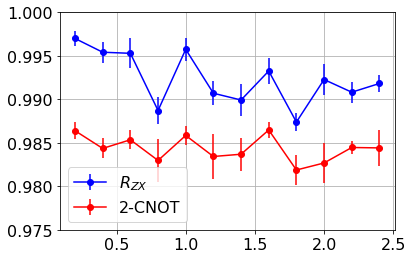

In [20]:
err_angle=[0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4]
#plt.style.use('seaborn-whitegrid')
#plt.plot(err_angle,Slope_fid,c='r')
plt.errorbar(err_angle,Slope_fid_pulse, yerr=Slope_fid_std_pulse,fmt='go-',color='b', ecolor='b', label='$R_{ZX}$')
#plt.plot(err_angle,Slope_fid_cnot,c='m')
plt.errorbar(err_angle,Slope_fid_cnt, yerr=Slope_fid_std_cnt,fmt='go-', color='r', ecolor='r', label='2-CNOT')
plt.legend()
plt.ylim(0.975, 1.0)
plt.grid()
plt.show()

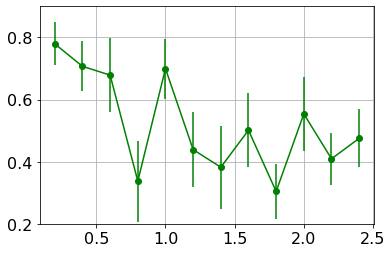

In [10]:
plt.plot(err_angle,Ratio,c='g')
plt.errorbar(err_angle,Ratio, yerr=Std_r, color='g', ecolor='g',fmt='o')
#plt.legend()
plt.ylim(0.2, 0.9)

plt.grid()
plt.show()